In [948]:
!python -V

Python 3.8.19


In [949]:
!nvidia-smi

Wed Aug 14 18:08:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:21:00.0 Off |                  Off |
| 42%   33C    P8             15W /  450W |    3487MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. 필수 라이브러리 설치 및 임포트

In [950]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/highsk88/Deeplearning_ADM/Autoencoder')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# 2. 데이터셋 및 데이터로더 생성

In [951]:
# MNIST 데이터셋 로드 및 전처리

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

mnist_train = datasets.MNIST(root='/home/highsk88/Deeplearning_ADM/Autoencoder', train=True, download=True, transform=transform)

# Normal data(숫자 '3'만 포함)를 훈련 데이터로 사용
normal_data = [img for img, label in mnist_train if label == 3]
normal_data = torch.stack(normal_data)

# Train/Validation split
train_size = int(0.8 * len(normal_data))
val_size = len(normal_data) - train_size
train_data, val_data = random_split(normal_data, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


# 3. Sparse Autoencoder 모델 정의

In [952]:
dropout_rate=0.5

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 28*28),
            nn.LeakyReLU(negative_slope=0.01)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# 4. 학습 함수 정의

In [953]:
# KL Divergence 정의
def kl_divergence(p, q, epsilon=1e-10):
    q = torch.clamp(q, min=epsilon, max=1-epsilon)
    return p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))

In [954]:
# 모델 가중치 초기화
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

In [955]:
model = SparseAutoencoder().to(device)
model.apply(weights_init)

# 학습 함수
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, l1_lambda=1e-5, sparsity_lambda=0.001, sparsity_target=0.3, clip_value=1.0, save_dir='models'):
    accumulation_steps = 4  # 배치 크기 증가
    early_stopping_threshold = 15
    best_loss = float('inf')
    patience = 0
    best_epoch = 0
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        
        for i, data in enumerate(train_loader):
            inputs = data.view(-1, 28*28).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            # Sparsity Regularization
            hidden_layer = model.encoder(inputs)
            sparsity_loss = sparsity_lambda * kl_divergence(sparsity_target, hidden_layer.mean(dim=0)).sum()
            loss += sparsity_loss
            
            # L1 규제
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
            
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        
            running_loss += loss.item() * inputs.size(0)
        
        scheduler.step()  
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # 검증 단계
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs = data.view(-1, 28*28).to(device)  
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # 조기 종료와 모델 저장
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch + 1
            patience = 0
            
            save_path = os.path.join(save_dir, f'best_model_epoch_{best_epoch}.pth')
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
            }, save_path)  
            print(f'Saving best model at epoch {epoch+1} to {save_path}')
        else:
            patience += 1
        
        if patience > early_stopping_threshold:
            print(f'Early stopping at epoch {epoch + 1}')
            break


# 5. 모델 학습

In [956]:
epoch = 1000

criterion = nn.SmoothL1Loss()

optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epoch)

Epoch 1/1000, train Loss: 0.9381, Validation Loss: 0.4462
Saving best model at epoch 1 to models/best_model_epoch_1.pth
Epoch 2/1000, train Loss: 0.7487, Validation Loss: 0.4437
Saving best model at epoch 2 to models/best_model_epoch_2.pth
Epoch 3/1000, train Loss: 0.6507, Validation Loss: 0.4430
Saving best model at epoch 3 to models/best_model_epoch_3.pth
Epoch 4/1000, train Loss: 0.5932, Validation Loss: 0.4447
Epoch 5/1000, train Loss: 0.5597, Validation Loss: 0.4440
Epoch 6/1000, train Loss: 0.5380, Validation Loss: 0.4419
Saving best model at epoch 6 to models/best_model_epoch_6.pth
Epoch 7/1000, train Loss: 0.5226, Validation Loss: 0.4448
Epoch 8/1000, train Loss: 0.5124, Validation Loss: 0.4445
Epoch 9/1000, train Loss: 0.5051, Validation Loss: 0.4454
Epoch 10/1000, train Loss: 0.4987, Validation Loss: 0.4460
Epoch 11/1000, train Loss: 0.4948, Validation Loss: 0.4461
Epoch 12/1000, train Loss: 0.4917, Validation Loss: 0.4450
Epoch 13/1000, train Loss: 0.4882, Validation Loss: 0

# 6. Best 모델 로드

In [960]:
def load_best_model(model, optimizer, scheduler, save_dir='models'):
    
    checkpoint_files = [f for f in os.listdir(save_dir) if f.startswith('best_model_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found in directory.")
    
    latest_file = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0])) 
    checkpoint_path = os.path.join(save_dir, latest_file)
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, scheduler, epoch, loss

model, optimizer, scheduler, best_epoch, best_loss = load_best_model(model, optimizer, scheduler, 'models')
model.to(device)  
print(f'Loaded model from epoch {best_epoch} with loss {best_loss:.4f}')

Loaded model from epoch 145 with loss 0.3860


/var/tmp/ipykernel_2801628/3856984529.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


# 7. 이상 탐지

In [961]:
def anomaly_detection(model, data_loader, threshold=0.1):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data.view(-1, 28*28).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            if loss.item() > threshold:
                anomalies.append((inputs.view(-1, 28, 28).cpu(), outputs.view(-1, 28, 28).cpu(), loss.item()))
    return anomalies


# 8. 시각화

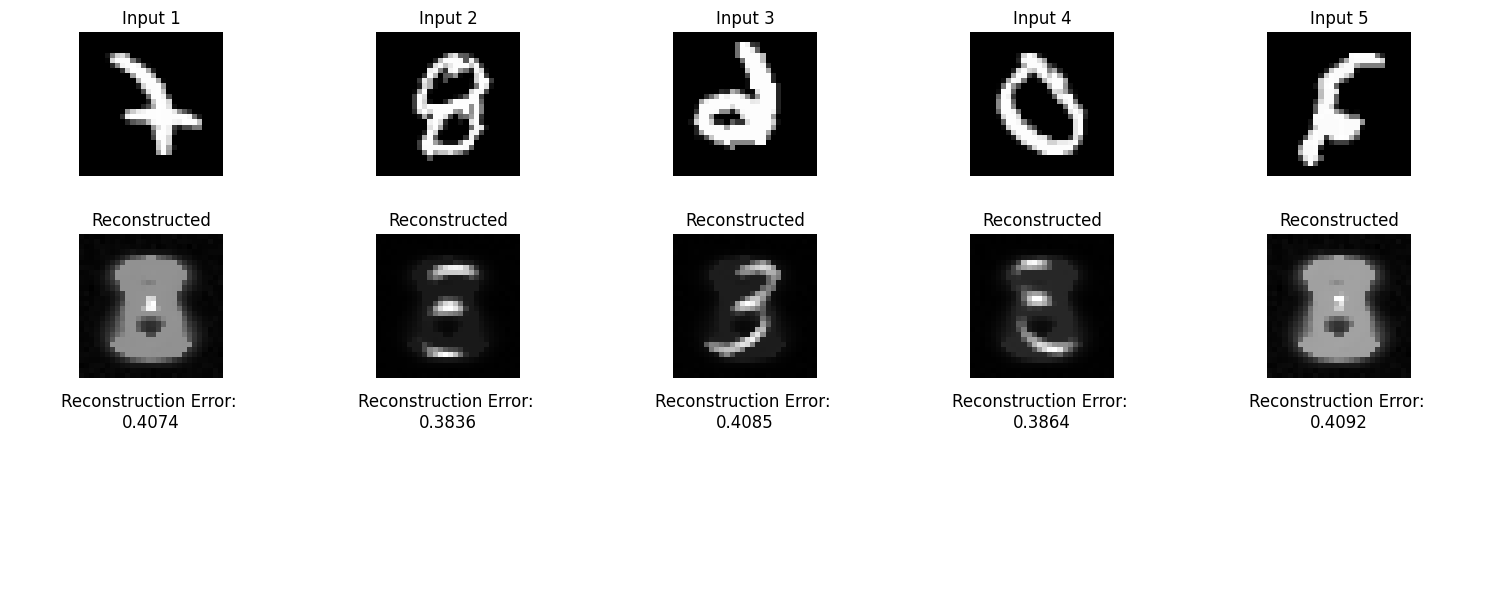

Average Reconstruction Error of displayed samples: 0.3990


In [964]:
def visualize_and_print_reconstruction_errors(anomalies, num_samples=5):
    plt.figure(figsize=(15, 6))
    total_loss = 0.0
    for i, (input_img, output_img, loss) in enumerate(anomalies[:num_samples]):
        plt.subplot(3, num_samples, i+1)
        plt.title(f"Input {i+1}")
        plt.imshow(input_img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.title("Reconstructed")
        plt.imshow(output_img.squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.title(f"Reconstruction Error: \n{loss:.4f}")
        plt.axis('off')
        
        total_loss += loss
    
    avg_reconstruction_error = total_loss / num_samples
    
    plt.tight_layout()
    plt.show()
    
    print(f'Average Reconstruction Error of displayed samples: {avg_reconstruction_error:.4f}')


# Test 데이터셋에 대해 이상 탐지 수행
test_data = datasets.MNIST(root='/home/highsk88/Deeplearning_ADM/Autoencoder', train=False, download=True, transform=transform)
test_loader = DataLoader([img for img, label in test_data if label != 1], batch_size=1, shuffle=True)

anomalies = anomaly_detection(model, test_loader,threshold=0.05)
visualize_and_print_reconstruction_errors(anomalies, num_samples=5)
